<a href="https://colab.research.google.com/github/AD1N23/mogo/blob/main/%D0%9B%D1%80_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Требования к отчету

Отчет должен быть оформлен в виде Jupyter Notebook и содержать следующие разделы:
1. Понимание бизнес-задачи: Описание задачи обнаружения аномалий и ее практической значимости.
2. Понимание данных: Описание используемого датасета, его характеристик, визуализация данных и аномалий.
3. Подготовка данных: Предобработка данных, масштабирование, создание последовательностей.
4. Моделирование: Создание и обучение моделей SimpleRNN, LSTM, Bidirectional LSTM и автоэнкодера.
5. Оценка моделей: Сравнение производительности моделей, анализ ошибок, интерпретация результатов.
6. Развертывание: Обсуждение возможностей применения моделей на практике.
7. Выводы: Обобщение результатов, сравнение архитектур, рекомендации по выбору модели для конкретных задач.


# Лабораторная работа №5


## Задание 1. Прогнозирование временных рядов

#### **Понимание бизнес-задачи:**
Целью данного проекта является построение моделей прогнозирования временного ряда на основе рекуррентных нейронных сетей (SimpleRNN, LSTM и Bidirectional LSTM) для предсказания количества международных авиапассажиров.

Прогнозирование таких данных важно для планирования ресурсов, логистики,
а также анализа рыночных тенденций в авиационной отрасли.

In [ ]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 86.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 120.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 115.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 119.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 6.0 MB/s eta 0:00:00


#### **Анализ данных**:

In [ ]:
#Импорт библиотек, загрузка данных
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Bidirectional
import math
# Загрузка данных
dataset = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
data = dataset.values.astype('float32')
print(dataset.head())

   Passengers
0         112
1         118
2         132
3         129
4         121


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141 entries, 0 to 140
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  141 non-null    int64
dtypes: int64(1)
memory usage: 1.2 KB


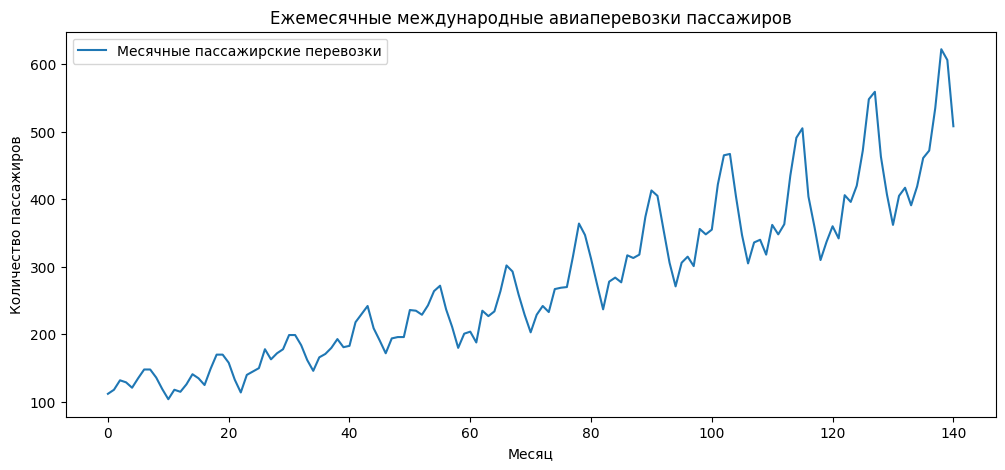

In [ ]:
# Визуализация исходного ряда
plt.figure(figsize=(12, 5))
plt.plot(dataset, label='Месячные пассажирские перевозки')
plt.title('Ежемесячные международные авиаперевозки пассажиров')
plt.xlabel('Месяц')
plt.ylabel('Количество пассажиров')
plt.legend()
plt.show()

График показывает ежегодный рост и сезонные колебания в пассажиропотоке.

#### **Подготовка данных:**

In [ ]:
# Нормализация данных
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

In [ ]:
# Разделение на обучающую и тестовую выборки
train_size = int(len(data) * 0.67)
test_size = len(data) - train_size
train, test = data[0:train_size,:], data[train_size:len(data),:]
print(f"Размер обучающей выборки: {len(train)}, размер тестовой выборки: {len(test)}")

Размер обучающей выборки: 94, размер тестовой выборки: 47


In [ ]:
# Функция для создания датасета с временными шагами
def create_dataset(dataset, look_back=1):
  X, Y = [], []
  for i in range(len(dataset) - look_back):
    X.append(dataset[i:(i + look_back), 0])
    Y.append(dataset[i + look_back, 0])
  return np.array(X), np.array(Y)

In [ ]:
# Создание датасетов с временными шагами
look_back = 3
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

#### **Моделирование**

In [ ]:
# Преобразование входных данных для RNN [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# Создание модели SimpleRNN
def create_simple_rnn_model():
  model = Sequential()
  model.add(SimpleRNN(units=50, activation='relu', input_shape=(look_back, 1)))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mean_squared_error')
  return model

# Обучение модели SimpleRNN
simple_rnn_model = create_simple_rnn_model()
simple_rnn_history = simple_rnn_model.fit(X_train, y_train, epochs=100, batch_size=32,
validation_data=(X_test, y_test), verbose=2)

# Прогнозирование
simple_rnn_train_predict = simple_rnn_model.predict(X_train)
simple_rnn_test_predict = simple_rnn_model.predict(X_test)

# Обратное преобразование прогнозов
simple_rnn_train_predict = scaler.inverse_transform(simple_rnn_train_predict)
simple_rnn_test_predict = scaler.inverse_transform(simple_rnn_test_predict)
y_train_inv = scaler.inverse_transform([y_train])
y_test_inv = scaler.inverse_transform([y_test])

# Расчет RMSE
simple_rnn_train_rmse = math.sqrt(mean_squared_error(y_train_inv[0], simple_rnn_train_predict[:,0]))
simple_rnn_test_rmse = math.sqrt(mean_squared_error(y_test_inv[0], simple_rnn_test_predict[:,0]))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
3/3 - 4s - 1s/step - loss: 0.0264 - val_loss: 0.1147
Epoch 2/100
3/3 - 0s - 45ms/step - loss: 0.0142 - val_loss: 0.0616
Epoch 3/100
3/3 - 0s - 45ms/step - loss: 0.0063 - val_loss: 0.0294
Epoch 4/100
3/3 - 0s - 24ms/step - loss: 0.0040 - val_loss: 0.0161
Epoch 5/100
3/3 - 0s - 24ms/step - loss: 0.0047 - val_loss: 0.0134
Epoch 6/100
3/3 - 0s - 24ms/step - loss: 0.0053 - val_loss: 0.0131
Epoch 7/100
3/3 - 0s - 24ms/step - loss: 0.0047 - val_loss: 0.0135
Epoch 8/100
3/3 - 0s - 26ms/step - loss: 0.0037 - val_loss: 0.0155
Epoch 9/100
3/3 - 0s - 23ms/step - loss: 0.0031 - val_loss: 0.0182
Epoch 10/100
3/3 - 0s - 24ms/step - loss: 0.0030 - val_loss: 0.0206
Epoch 11/100
3/3 - 0s - 22ms/step - loss: 0.0032 - val_loss: 0.0212
Epoch 12/100
3/3 - 0s - 62ms/step - loss: 0.0032 - val_loss: 0.0198
Epoch 13/100
3/3 - 0s - 33ms/step - loss: 0.0030 - val_loss: 0.0172
Epoch 14/100
3/3 - 0s - 46ms/step - loss: 0.0028 - val_loss: 0.0148
Epoch 15/100
3/3 - 0s - 24ms/step - loss: 0.0027 - val_loss

In [ ]:
def create_lstm_model():
  model = Sequential()
  model.add(LSTM(units=50, activation='relu', input_shape=(look_back, 1)))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mean_squared_error')
  return model

# Обучение модели LSTM
lstm_model = create_lstm_model()
lstm_history = lstm_model.fit(X_train, y_train, epochs=100, batch_size=32,
validation_data=(X_test, y_test), verbose=2)

# Прогнозирование
lstm_train_predict = lstm_model.predict(X_train)
lstm_test_predict = lstm_model.predict(X_test)

# Обратное преобразование прогнозов
lstm_train_predict = scaler.inverse_transform(lstm_train_predict)
lstm_test_predict = scaler.inverse_transform(lstm_test_predict)

# Расчет RMSE
lstm_train_rmse = math.sqrt(mean_squared_error(y_train_inv[0], lstm_train_predict[:,0]))
lstm_test_rmse = math.sqrt(mean_squared_error(y_test_inv[0], lstm_test_predict[:,0]))

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 - 4s - 1s/step - loss: 0.0775 - val_loss: 0.4470
Epoch 2/100
3/3 - 3s - 856ms/step - loss: 0.0704 - val_loss: 0.4212
Epoch 3/100
3/3 - 0s - 42ms/step - loss: 0.0644 - val_loss: 0.3967
Epoch 4/100
3/3 - 0s - 46ms/step - loss: 0.0587 - val_loss: 0.3740
Epoch 5/100
3/3 - 0s - 45ms/step - loss: 0.0533 - val_loss: 0.3530
Epoch 6/100
3/3 - 0s - 23ms/step - loss: 0.0486 - val_loss: 0.3330
Epoch 7/100
3/3 - 0s - 48ms/step - loss: 0.0446 - val_loss: 0.3138
Epoch 8/100
3/3 - 0s - 45ms/step - loss: 0.0405 - val_loss: 0.2955
Epoch 9/100
3/3 - 0s - 23ms/step - loss: 0.0366 - val_loss: 0.2779
Epoch 10/100
3/3 - 0s - 63ms/step - loss: 0.0332 - val_loss: 0.2605
Epoch 11/100
3/3 - 0s - 24ms/step - loss: 0.0298 - val_loss: 0.2432
Epoch 12/100
3/3 - 0s - 45ms/step - loss: 0.0266 - val_loss: 0.2260
Epoch 13/100
3/3 - 0s - 46ms/step - loss: 0.0239 - val_loss: 0.2089
Epoch 14/100
3/3 - 0s - 48ms/step - loss: 0.0210 - val_loss: 0.1922
Epoch 15/100
3/3 - 0s - 46ms/step - loss: 0.0187 - val_loss: 0.1759
Ep

In [ ]:
# Создание модели Bidirectional LSTM
def create_bidirectional_lstm_model():
  model = Sequential()
  model.add(Bidirectional(LSTM(units=50, activation='relu'), input_shape=(look_back, 1)))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mean_squared_error')
  return model

# Обучение модели Bidirectional LSTM
bidirectional_lstm_model = create_bidirectional_lstm_model()
bidirectional_lstm_history = bidirectional_lstm_model.fit(X_train, y_train, epochs=100, batch_size=32,
validation_data=(X_test, y_test),verbose=2)

# Прогнозирование
bidirectional_lstm_train_predict = bidirectional_lstm_model.predict(X_train)
bidirectional_lstm_test_predict = bidirectional_lstm_model.predict(X_test)

# Обратное преобразование прогнозов
bidirectional_lstm_train_predict = scaler.inverse_transform(bidirectional_lstm_train_predict)
bidirectional_lstm_test_predict = scaler.inverse_transform(bidirectional_lstm_test_predict)

# Расчет RMSE
bidirectional_lstm_train_rmse = math.sqrt(mean_squared_error(y_train_inv[0], bidirectional_lstm_train_predict[:,0]))
bidirectional_lstm_test_rmse = math.sqrt(mean_squared_error(y_test_inv[0], bidirectional_lstm_test_predict[:,0]))

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 - 5s - 2s/step - loss: 0.0651 - val_loss: 0.3671
Epoch 2/100
3/3 - 0s - 27ms/step - loss: 0.0564 - val_loss: 0.3322
Epoch 3/100
3/3 - 0s - 45ms/step - loss: 0.0488 - val_loss: 0.2993
Epoch 4/100
3/3 - 0s - 25ms/step - loss: 0.0416 - val_loss: 0.2683
Epoch 5/100
3/3 - 0s - 25ms/step - loss: 0.0350 - val_loss: 0.2388
Epoch 6/100
3/3 - 0s - 24ms/step - loss: 0.0295 - val_loss: 0.2105
Epoch 7/100
3/3 - 0s - 47ms/step - loss: 0.0241 - val_loss: 0.1841
Epoch 8/100
3/3 - 0s - 25ms/step - loss: 0.0200 - val_loss: 0.1590
Epoch 9/100
3/3 - 0s - 29ms/step - loss: 0.0161 - val_loss: 0.1359
Epoch 10/100
3/3 - 0s - 40ms/step - loss: 0.0133 - val_loss: 0.1147
Epoch 11/100
3/3 - 0s - 46ms/step - loss: 0.0110 - val_loss: 0.0963
Epoch 12/100
3/3 - 0s - 24ms/step - loss: 0.0095 - val_loss: 0.0808
Epoch 13/100
3/3 - 0s - 46ms/step - loss: 0.0091 - val_loss: 0.0679
Epoch 14/100
3/3 - 0s - 24ms/step - loss: 0.0086 - val_loss: 0.0590
Epoch 15/100
3/3 - 0s - 23ms/step - loss: 0.0083 - val_loss: 0.0536
Epo

1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


#### **Оценка моделей**

In [ ]:
print(f'SimpleRNN - Ошибка на обучающей выборке (RMSE): {simple_rnn_train_rmse:.5f}')
print(f'SimpleRNN - Ошибка на тестовой выборке (RMSE): {simple_rnn_test_rmse:.5f}\n')

print(f'LSTM - Ошибка на обучающей выборке (RMSE): {lstm_train_rmse:.5f}')
print(f'LSTM - Ошибка на тестовой выборке (RMSE): {lstm_test_rmse:.5f}\n')

print(f'Bidirectional LSTM - Ошибка на обучающей выборке (RMSE): {bidirectional_lstm_train_rmse:.5f}')
print(f'Bidirectional LSTM - Ошибка на тестовой выборке (RMSE): {bidirectional_lstm_test_rmse:.5f}')



SimpleRNN - Ошибка на обучающей выборке (RMSE): 21.14256
SimpleRNN - Ошибка на тестовой выборке (RMSE): 52.37582

LSTM - Ошибка на обучающей выборке (RMSE): 29.42536
LSTM - Ошибка на тестовой выборке (RMSE): 74.73651

Bidirectional LSTM - Ошибка на обучающей выборке (RMSE): 27.29585
Bidirectional LSTM - Ошибка на тестовой выборке (RMSE): 64.82302


In [ ]:
# Подготовка данных для визуализации
train_plot = np.empty_like(data)
train_plot[:, :] = np.nan
train_plot[look_back:len(simple_rnn_train_predict) + look_back, :] = simple_rnn_train_predict
test_plot = np.empty_like(data)
test_plot[:, :] = np.nan
test_plot[len(simple_rnn_train_predict) + (look_back * 2):len(data), :] = simple_rnn_test_predict


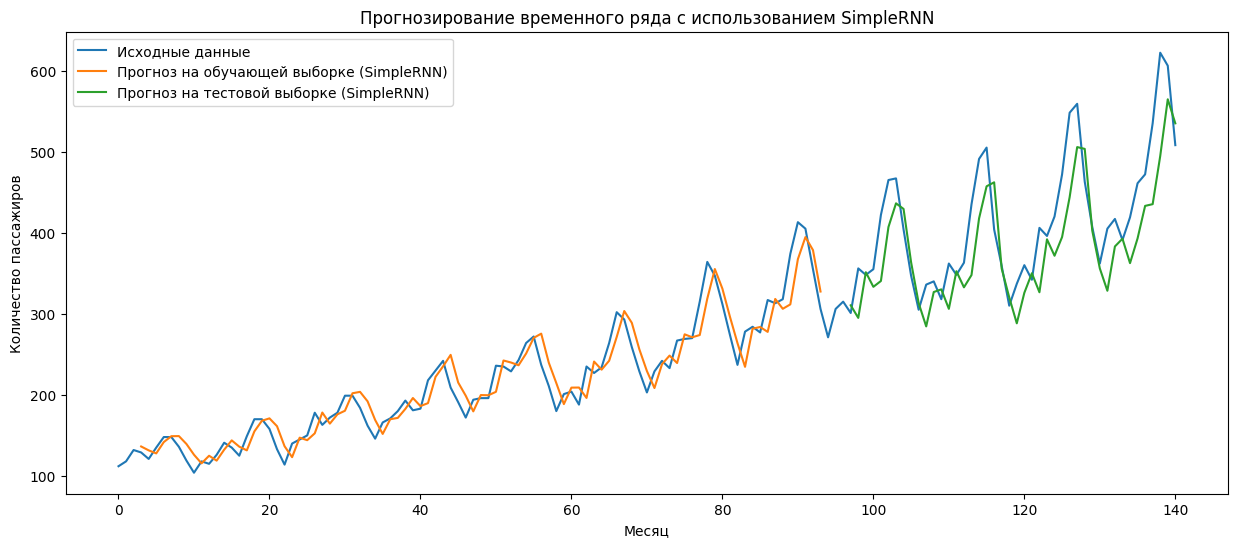

In [ ]:
# Визуализация результатов SimpleRNN
plt.figure(figsize=(15, 6))
plt.plot(scaler.inverse_transform(data), label='Исходные данные')
plt.plot(train_plot, label='Прогноз на обучающей выборке (SimpleRNN)')
plt.plot(test_plot, label='Прогноз на тестовой выборке (SimpleRNN)')
plt.title('Прогнозирование временного ряда с использованием SimpleRNN')
plt.xlabel('Месяц')
plt.ylabel('Количество пассажиров')
plt.legend()
plt.show()

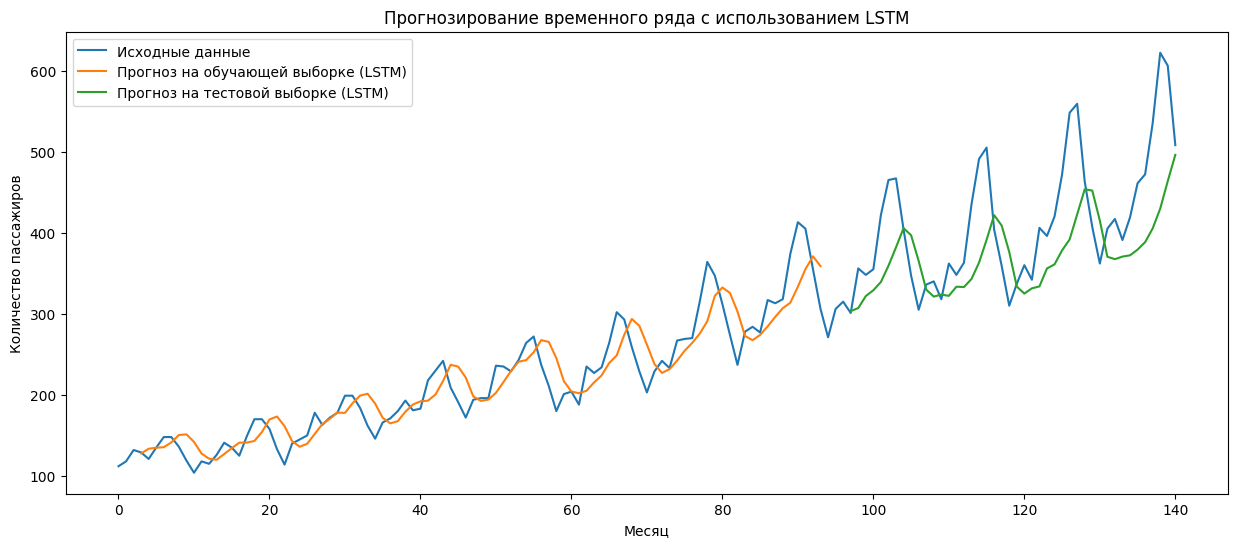

In [ ]:
# Подготовка данных для визуализации
train_plot = np.empty_like(data)
train_plot[:, :] = np.nan
train_plot[look_back:len(lstm_train_predict) + look_back, :] = lstm_train_predict

test_plot = np.empty_like(data)
test_plot[:, :] = np.nan
test_plot[len(lstm_train_predict) + (look_back * 2):len(data), :] = lstm_test_predict

# Визуализация результатов LSTM
plt.figure(figsize=(15, 6))
plt.plot(scaler.inverse_transform(data), label='Исходные данные')
plt.plot(train_plot, label='Прогноз на обучающей выборке (LSTM)')
plt.plot(test_plot, label='Прогноз на тестовой выборке (LSTM)')
plt.title('Прогнозирование временного ряда с использованием LSTM')
plt.xlabel('Месяц')
plt.ylabel('Количество пассажиров')
plt.legend()
plt.show()

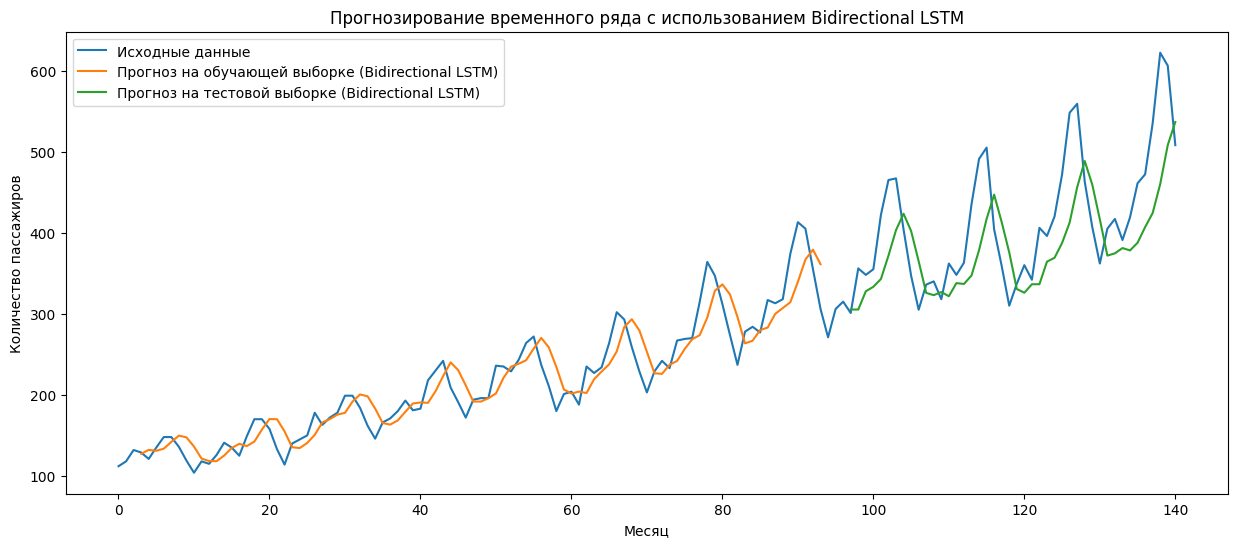

In [ ]:
# Подготовка данных для визуализации
train_plot = np.empty_like(data)
train_plot[:, :] = np.nan
train_plot[look_back:len(bidirectional_lstm_train_predict ) + look_back, :] = bidirectional_lstm_train_predict

test_plot = np.empty_like(data)
test_plot[:, :] = np.nan
test_plot[len(bidirectional_lstm_train_predict ) + (look_back * 2):len(data), :] = bidirectional_lstm_test_predict

# Визуализация результатов Bidirectional LSTM
plt.figure(figsize=(15, 6))
plt.plot(scaler.inverse_transform(data), label='Исходные данные')
plt.plot(train_plot, label='Прогноз на обучающей выборке (Bidirectional LSTM)')
plt.plot(test_plot, label='Прогноз на тестовой выборке (Bidirectional LSTM)')
plt.title('Прогнозирование временного ряда с использованием Bidirectional LSTM')
plt.xlabel('Месяц')
plt.ylabel('Количество пассажиров')
plt.legend()
plt.show()

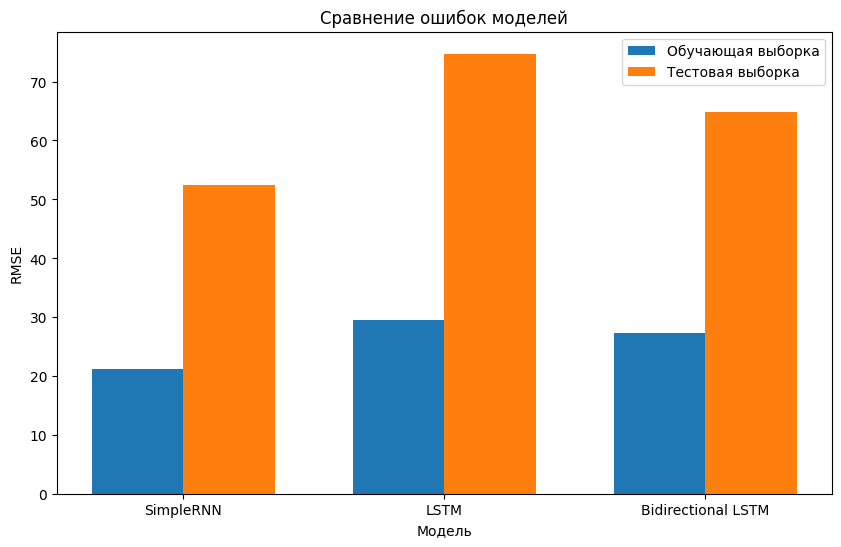

In [ ]:
# Сравнение ошибок моделей
models = ['SimpleRNN', 'LSTM', 'Bidirectional LSTM']
train_rmse = [simple_rnn_train_rmse, lstm_train_rmse, bidirectional_lstm_train_rmse]
test_rmse = [simple_rnn_test_rmse, lstm_test_rmse, bidirectional_lstm_test_rmse]
plt.figure(figsize=(10, 6))
x = np.arange(len(models))
width = 0.35
plt.bar(x - width/2, train_rmse, width, label='Обучающая выборка')
plt.bar(x + width/2, test_rmse, width, label='Тестовая выборка')
plt.xlabel('Модель')
plt.ylabel('RMSE')
plt.title('Сравнение ошибок моделей')
plt.xticks(x, models)
plt.legend()
plt.show()

#### **Развертывание**

Модель может быть внедрена в:

- BI-платформы для прогнозной аналитики

- Информационные панели для оперативного управления

- Системы автоматического планирования маршрутов

Преимущества:

- Поддержка адаптивного прогнозирования

- Возможность дообучения при поступлении новых данных

- Расширяемость (добавление новых признаков, например сезонных)

#### **Выводы**

Для прогнозирования лучше всего использовать модель SimpleRNN, как дающую наименьшую ошибку.

## Задание 3. Классификация последовательностей MNIST

#### **Понимание бизнес-задачи**

Анализ тональности текста — это ключевая задача в области обработки естественного языка (NLP), которая позволяет определить эмоциональную окраску высказываний: положительную, отрицательную или нейтральную. Это особенно важно для компаний, стремящихся понять реакцию клиентов на продукты, услуги или контент.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Bidirectional, Dropout
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

# Загрузка данных
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


#### Анализ данных

In [ ]:
# Вывод информации о данных
print(f'Форма обучающих данных: {x_train.shape}')
print(f'Форма тестовых данных: {x_test.shape}')

Форма обучающих данных: (60000, 28, 28)
Форма тестовых данных: (10000, 28, 28)


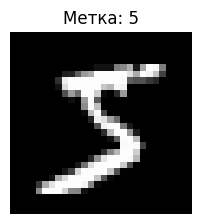

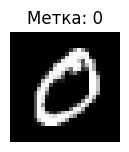

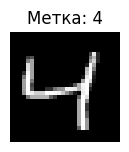

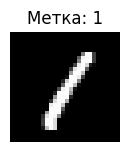

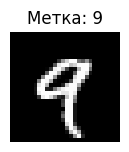

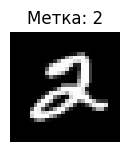

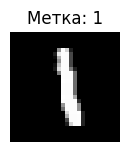

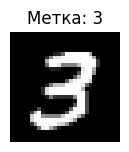

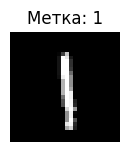

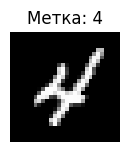

In [ ]:
# Визуализация примеров изображений
plt.figure(figsize=(10, 5))
for i in range(10):
  plt.subplot(2, 5, i+1)
  plt.imshow(x_train[i], cmap='gray')
  plt.title(f'Метка: {y_train[i]}')
  plt.axis('off')
  plt.tight_layout()
  plt.show()


In [ ]:
# Нормализация данных
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Преобразование меток в категориальный формат (one-hot encoding)
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

#### **Моделирование**

In [ ]:
def evaluate_model(model, x_test, y_test, y_test_cat):
  # Предсказание классов
  y_pred_prob = model.predict(x_test)
  y_pred = np.argmax(y_pred_prob, axis=1)

  # Расчет точности
  accuracy = accuracy_score(y_test, y_pred)
  print(f'Точность (Accuracy): {accuracy:.4f}')

  # Вывод отчета о классификации
  print('\nОтчет о классификации:')
  print(classification_report(y_test, y_pred))

  # Построение матрицы ошибок
  cm = confusion_matrix(y_test, y_pred)
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
  plt.title('Матрица ошибок')
  plt.xlabel('Предсказанные метки')
  plt.ylabel('Истинные метки')
  plt.show()
  return accuracy

In [ ]:
def create_simple_rnn_model():
  model = Sequential()
  # Входные данные: (batch_size, timesteps, input_dim) = (batch_size, 28, 28)
  # Каждая строка изображения рассматривается как временной шаг
  model.add(SimpleRNN(units=128, input_shape=(28, 28), activation='relu', return_sequences=True))
  model.add(SimpleRNN(units=64, activation='relu'))
  model.add(Dense(10, activation='softmax'))
  model.compile(loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy'])
  return model

# Обучение модели SimpleRNN
print('Обучение модели SimpleRNN...')
simple_rnn_model = create_simple_rnn_model()
simple_rnn_history = simple_rnn_model.fit(x_train, y_train_cat,
                                            batch_size=128,
                                            epochs=10,
                                            validation_data=(x_test, y_test_cat),
                                            verbose=2)


Обучение модели SimpleRNN...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
469/469 - 12s - 25ms/step - accuracy: 0.8401 - loss: 0.4970 - val_accuracy: 0.9343 - val_loss: 0.2171
Epoch 2/10
469/469 - 9s - 20ms/step - accuracy: 0.9478 - loss: 0.1740 - val_accuracy: 0.9599 - val_loss: 0.1315
Epoch 3/10
469/469 - 9s - 20ms/step - accuracy: 0.9629 - loss: 0.1270 - val_accuracy: 0.9633 - val_loss: 0.1231
Epoch 4/10
469/469 - 9s - 20ms/step - accuracy: 0.9664 - loss: 0.1125 - val_accuracy: 0.9667 - val_loss: 0.1136
Epoch 5/10
469/469 - 9s - 20ms/step - accuracy: 0.9712 - loss: 0.0981 - val_accuracy: 0.9657 - val_loss: 0.1298
Epoch 6/10
469/469 - 9s - 20ms/step - accuracy: 0.9754 - loss: 0.0825 - val_accuracy: 0.9697 - val_loss: 0.1026
Epoch 7/10
469/469 - 9s - 20ms/step - accuracy: 0.9762 - loss: 0.0819 - val_accuracy: 0.9774 - val_loss: 0.0780
Epoch 8/10
469/469 - 9s - 20ms/step - accuracy: 0.9777 - loss: 0.0743 - val_accuracy: 0.9788 - val_loss: 0.0740
Epoch 9/10
469/469 - 9s - 20ms/step - accuracy: 0.9796 - loss: 0.0684 - val_accuracy: 0.9814 - val_loss

In [ ]:
# Создание модели LSTM
def create_lstm_model():
  model = Sequential()
  model.add(LSTM(units=128, input_shape=(28, 28), activation='relu', return_sequences=True))
  model.add(LSTM(units=64, activation='relu'))
  model.add(Dense(10, activation='softmax'))
  model.compile(loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy'])
  return model

# Обучение модели LSTM
print('Обучение модели LSTM...')
lstm_model = create_lstm_model()
lstm_history = lstm_model.fit(x_train, y_train_cat,
                              batch_size=128,
                              epochs=10,
                              validation_data=(x_test, y_test_cat),
                              verbose=2)


Обучение модели LSTM...
Epoch 1/10
469/469 - 57s - 121ms/step - accuracy: 0.8094 - loss: 0.5814 - val_accuracy: 0.9319 - val_loss: 0.2144
Epoch 2/10
469/469 - 54s - 115ms/step - accuracy: 0.9543 - loss: 0.1483 - val_accuracy: 0.9698 - val_loss: 0.1027
Epoch 3/10
469/469 - 54s - 115ms/step - accuracy: 0.9688 - loss: 0.1010 - val_accuracy: 0.9752 - val_loss: 0.0798
Epoch 4/10
469/469 - 54s - 114ms/step - accuracy: 0.9765 - loss: 0.0754 - val_accuracy: 0.9802 - val_loss: 0.0607
Epoch 5/10
469/469 - 54s - 115ms/step - accuracy: 0.9800 - loss: 0.0631 - val_accuracy: 0.9844 - val_loss: 0.0504
Epoch 6/10
469/469 - 54s - 114ms/step - accuracy: 0.9820 - loss: 0.0571 - val_accuracy: 0.9824 - val_loss: 0.0602
Epoch 7/10
469/469 - 54s - 115ms/step - accuracy: 0.9849 - loss: 0.0505 - val_accuracy: 0.9841 - val_loss: 0.0530
Epoch 8/10
469/469 - 54s - 115ms/step - accuracy: 0.9861 - loss: 0.0439 - val_accuracy: 0.9841 - val_loss: 0.0475
Epoch 9/10
469/469 - 54s - 115ms/step - accuracy: 0.9883 - loss:

In [ ]:
# Создание модели Bidirectional LSTM
def create_bidirectional_lstm_model():
  model = Sequential()
  model.add(Bidirectional(LSTM(units=128, activation='relu', return_sequences=True), input_shape=(28, 28)))
  model.add(Bidirectional(LSTM(units=64, activation='relu')))
  model.add(Dense(10, activation='softmax'))
  model.compile(loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy'])
  return model


# Обучение модели Bidirectional LSTM
print('Обучение модели Bidirectional LSTM...')
bidirectional_lstm_model = create_bidirectional_lstm_model()
bidirectional_lstm_history = bidirectional_lstm_model.fit(x_train, y_train_cat,
                                                          batch_size=128,
                                                          epochs=10,
                                                          validation_data=(x_test, y_test_cat),
                                                          verbose=2)


Обучение модели Bidirectional LSTM...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
469/469 - 194s - 414ms/step - accuracy: 0.8217 - loss: 0.5654 - val_accuracy: 0.9468 - val_loss: 0.1641
Epoch 2/10
469/469 - 188s - 401ms/step - accuracy: 0.9552 - loss: 0.1434 - val_accuracy: 0.9674 - val_loss: 0.1025
Epoch 3/10
469/469 - 188s - 400ms/step - accuracy: 0.9702 - loss: 0.0947 - val_accuracy: 0.9759 - val_loss: 0.0747
Epoch 4/10
469/469 - 187s - 399ms/step - accuracy: 0.9750 - loss: 0.0793 - val_accuracy: 0.9704 - val_loss: 0.0947
Epoch 5/10
469/469 - 188s - 400ms/step - accuracy: 0.9796 - loss: 0.0628 - val_accuracy: 0.9772 - val_loss: 0.0731
Epoch 6/10
469/469 - 188s - 401ms/step - accuracy: 0.9832 - loss: 0.0530 - val_accuracy: 0.9852 - val_loss: 0.0476
Epoch 7/10
469/469 - 188s - 400ms/step - accuracy: 0.9840 - loss: 0.0505 - val_accuracy: 0.9830 - val_loss: 0.0514
Epoch 8/10
469/469 - 187s - 399ms/step - accuracy: 0.9876 - loss: 0.0381 - val_accuracy: 0.9791 - val_loss: 0.0678
Epoch 9/10
469/469 - 187s - 399ms/step - accuracy: 0.9878 - loss: 0.0371 - val_a

#### **Оценка моделей**


Оценка модели SimpleRNN:
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Точность (Accuracy): 0.9766

Отчет о классификации:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.96      0.97      1032
           3       0.99      0.97      0.98      1010
           4       0.99      0.98      0.98       982
           5       0.93      1.00      0.96       892
           6       0.96      0.99      0.98       958
           7       0.98      0.97      0.98      1028
           8       0.98      0.97      0.97       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



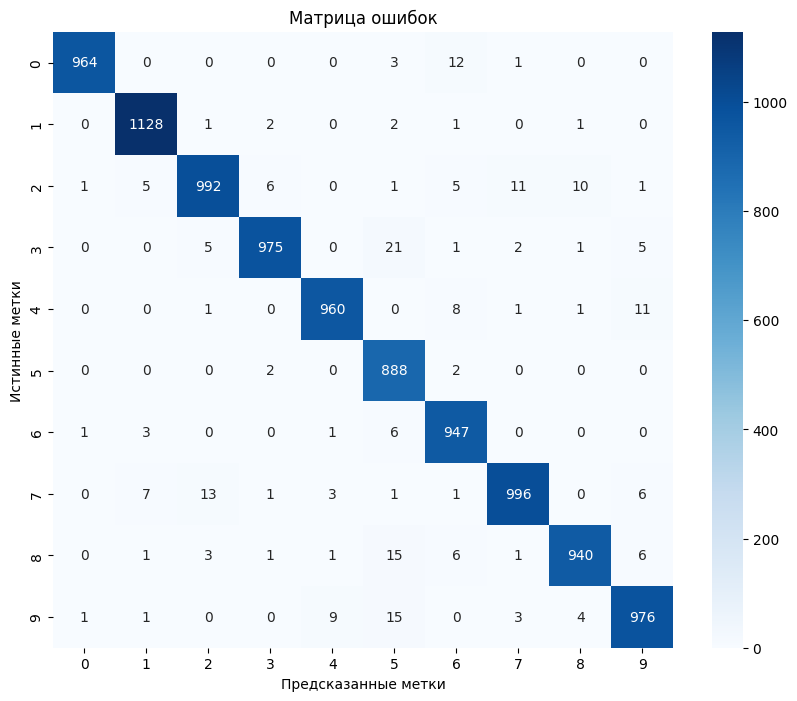


Оценка модели LSTM:
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
Точность (Accuracy): 0.9847

Отчет о классификации:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.99      0.99      1032
           3       0.98      0.99      0.99      1010
           4       0.96      1.00      0.98       982
           5       0.98      0.98      0.98       892
           6       0.99      0.97      0.98       958
           7       0.99      0.98      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.99      0.97      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



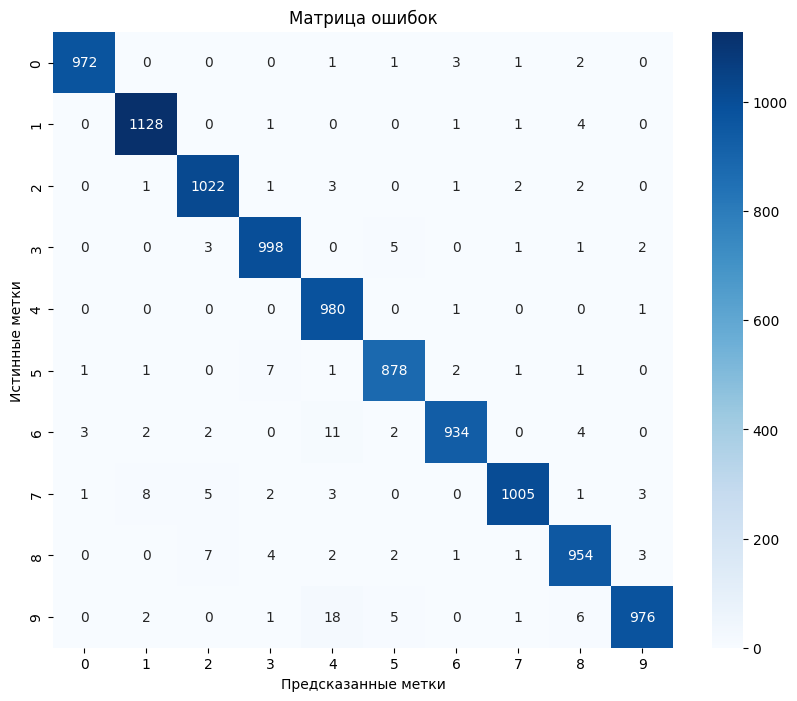


Оценка модели Bidirectional LSTM:
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step
Точность (Accuracy): 0.9848

Отчет о классификации:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.97      0.99      0.98      1032
           3       0.98      0.99      0.98      1010
           4       0.98      0.99      0.99       982
           5       0.99      0.98      0.98       892
           6       0.99      0.99      0.99       958
           7       0.99      0.96      0.98      1028
           8       0.99      0.97      0.98       974
           9       0.97      0.99      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



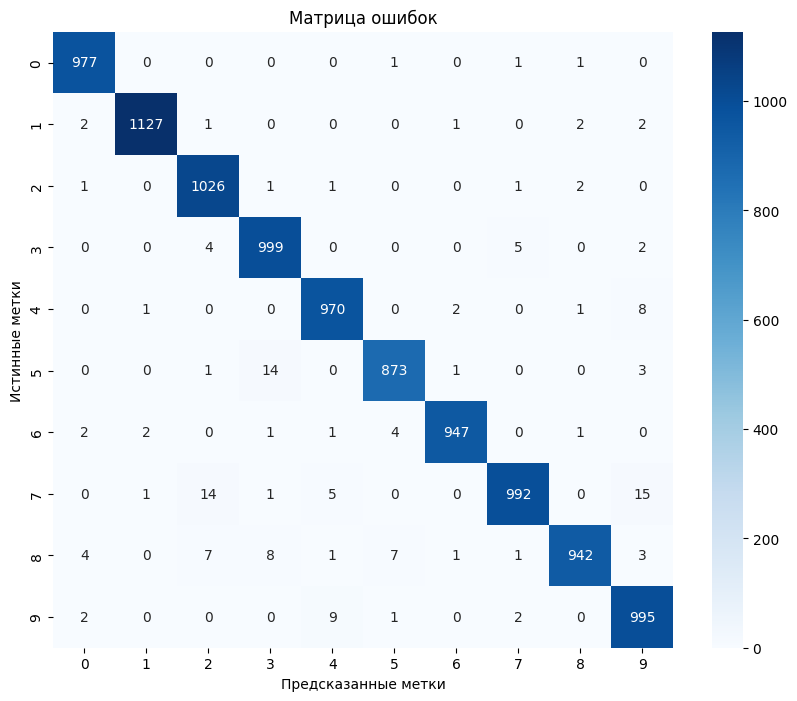

In [ ]:
print('\nОценка модели SimpleRNN:')
simple_rnn_accuracy = evaluate_model(simple_rnn_model, x_test, y_test, y_test_cat)

# Оценка модели LSTM
print('\nОценка модели LSTM:')
lstm_accuracy = evaluate_model(lstm_model, x_test, y_test, y_test_cat)

# Оценка модели Bidirectional LSTM
print('\nОценка модели Bidirectional LSTM:')
bidirectional_lstm_accuracy = evaluate_model(bidirectional_lstm_model, x_test, y_test, y_test_cat)


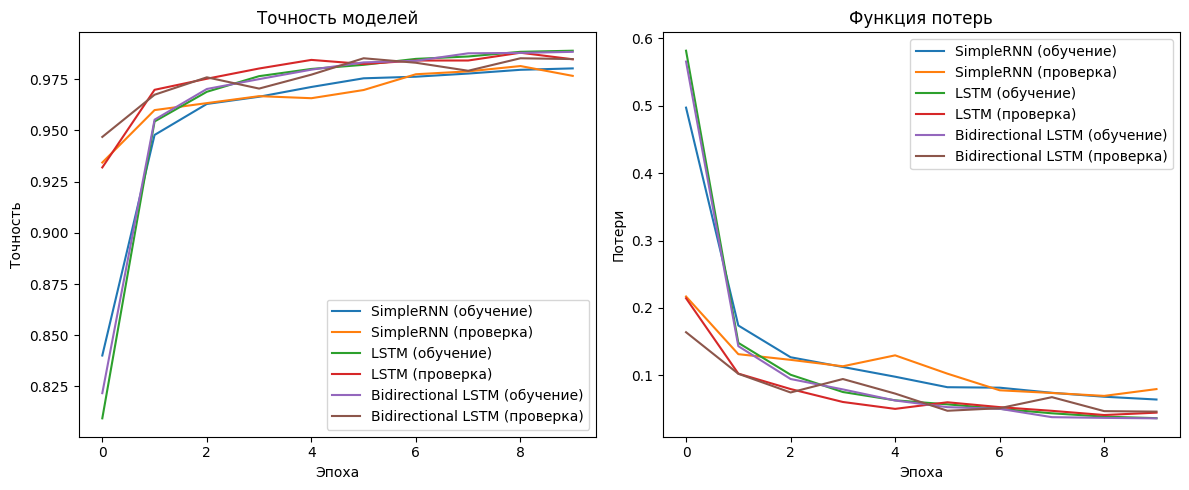

In [ ]:
# Визуализация точности на обучающей и проверочной выборках
def plot_history(histories, names):
  plt.figure(figsize=(12, 5))
  # График точности
  plt.subplot(1, 2, 1)
  for i, history in enumerate(histories):
    plt.plot(history.history['accuracy'], label=f'{names[i]} (обучение)')
    plt.plot(history.history['val_accuracy'], label=f'{names[i]} (проверка)')
    plt.title('Точность моделей')
    plt.xlabel('Эпоха')
    plt.ylabel('Точность')
    plt.legend()
  # График функции потерь
  plt.subplot(1, 2, 2)
  for i, history in enumerate(histories):
    plt.plot(history.history['loss'], label=f'{names[i]} (обучение)')
    plt.plot(history.history['val_loss'], label=f'{names[i]} (проверка)')
    plt.title('Функция потерь')
    plt.xlabel('Эпоха')
    plt.ylabel('Потери')
    plt.legend()
  plt.tight_layout()
  plt.show()


# Визуализация результатов обучения
histories = [simple_rnn_history, lstm_history, bidirectional_lstm_history]
names = ['SimpleRNN', 'LSTM', 'Bidirectional LSTM']
plot_history(histories, names)

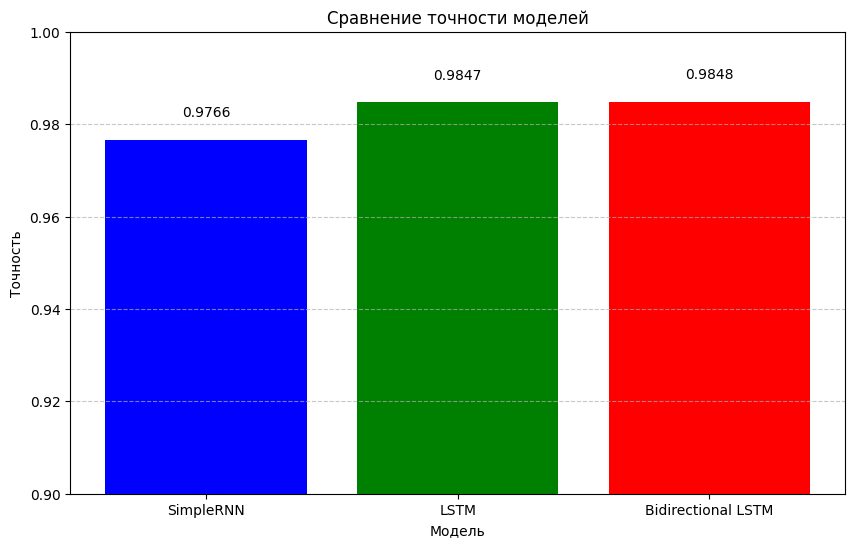

In [ ]:
# Сравнение точности моделей
accuracies = [simple_rnn_accuracy, lstm_accuracy, bidirectional_lstm_accuracy]
plt.figure(figsize=(10, 6))
plt.bar(names, accuracies, color=['blue', 'green', 'red'])
plt.title('Сравнение точности моделей')
plt.xlabel('Модель')
plt.ylabel('Точность')
plt.ylim(0.9, 1.0) # Настройте в зависимости от результатов
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, acc in enumerate(accuracies):
  plt.text(i, acc + 0.005, f'{acc:.4f}', ha='center')
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Примеры неправильно классифицированных изображений (SimpleRNN):


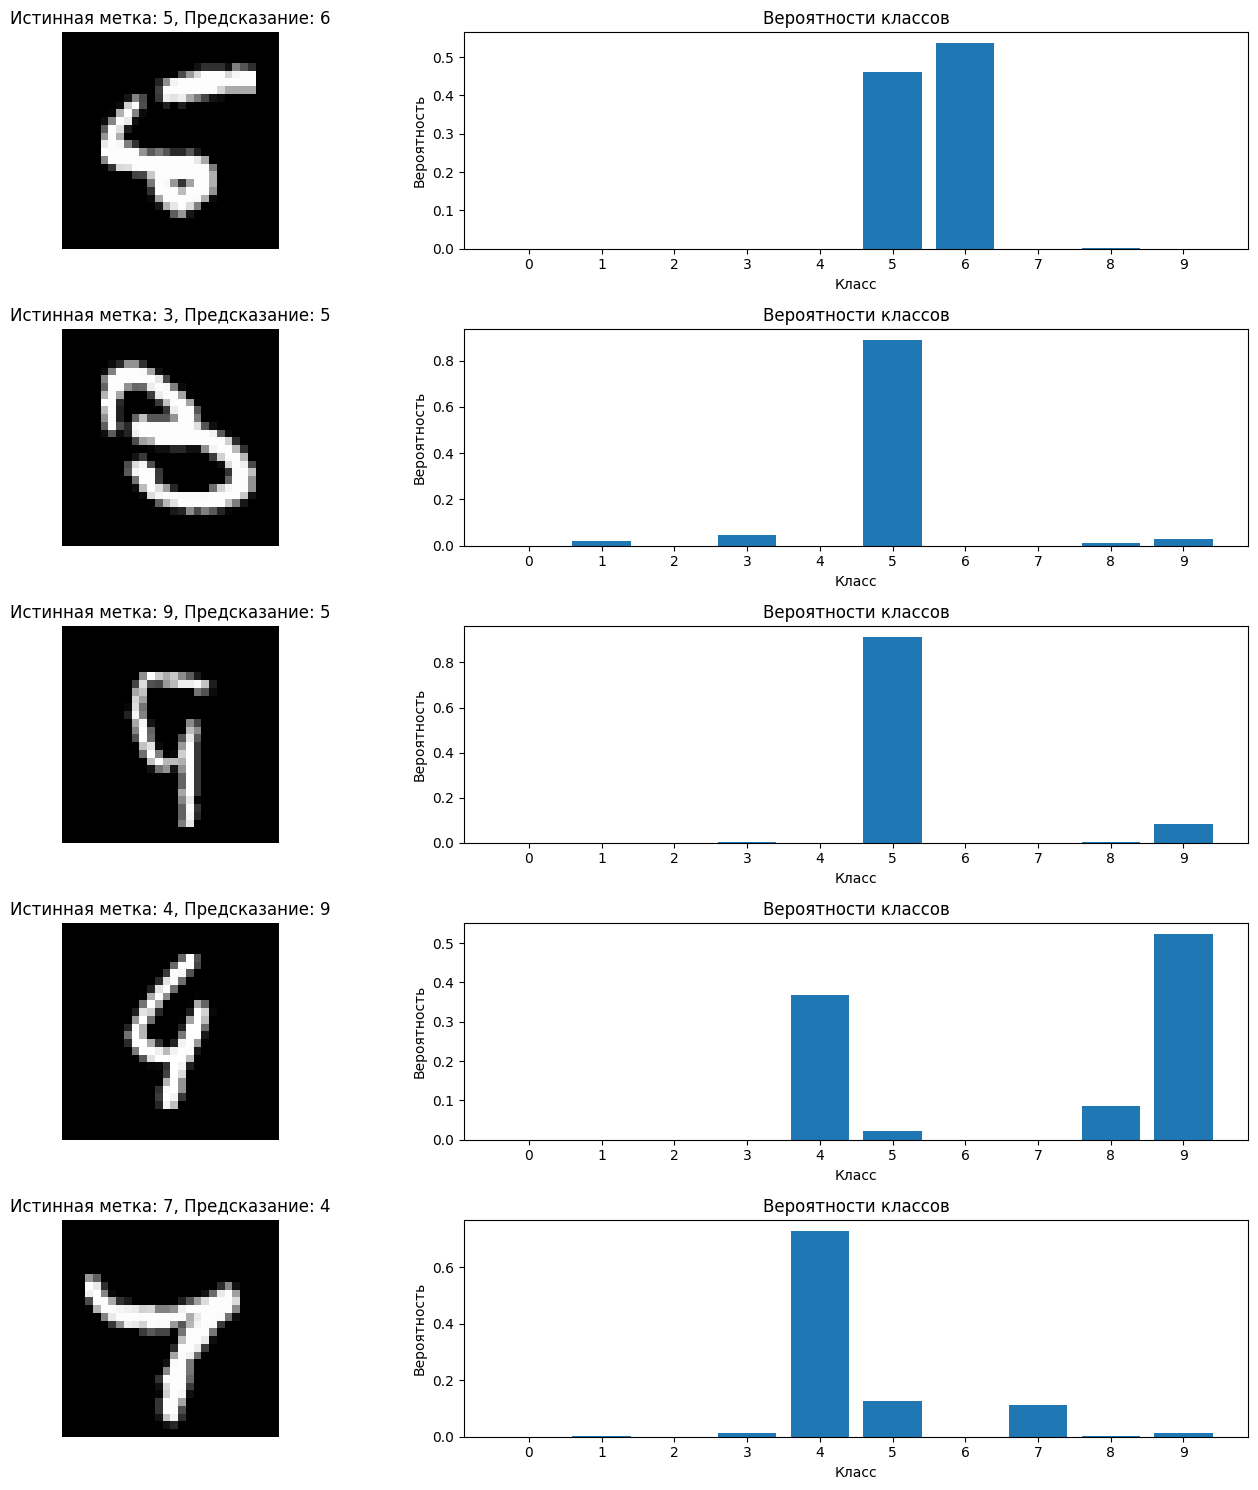

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
Примеры неправильно классифицированных изображений (LSTM):


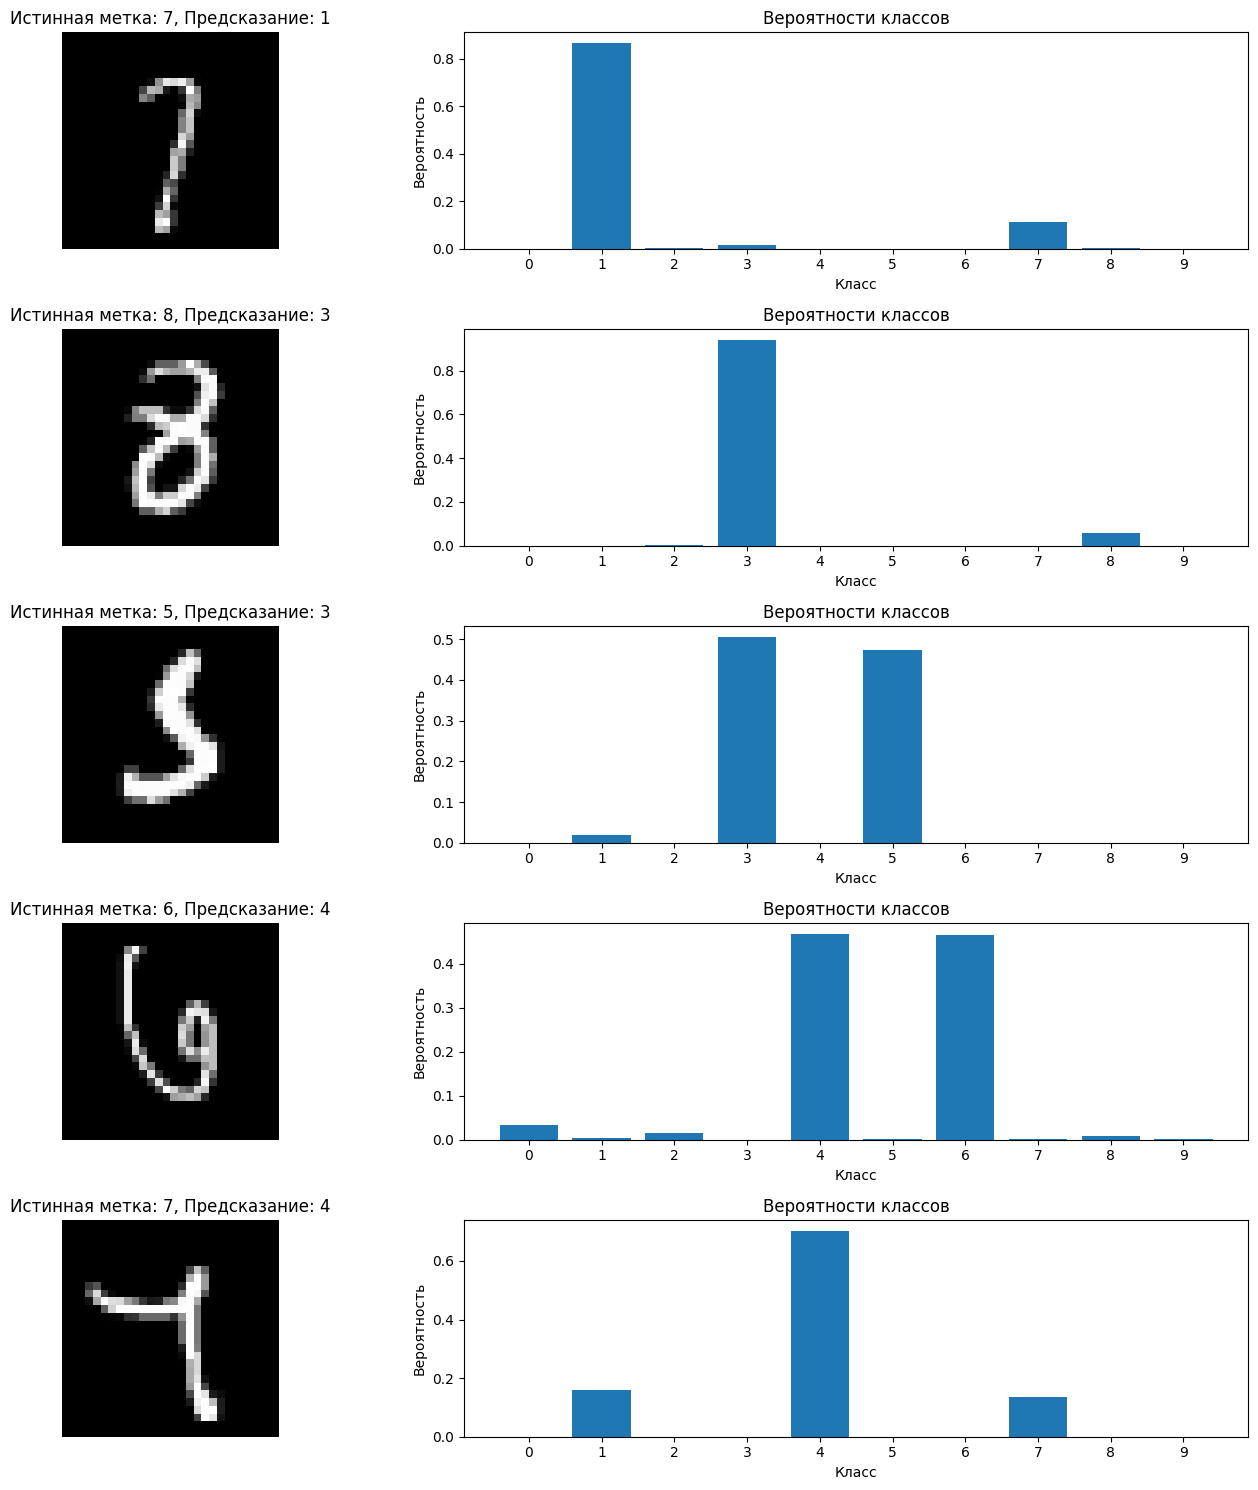

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step
Примеры неправильно классифицированных изображений (Bidirectional LSTM):


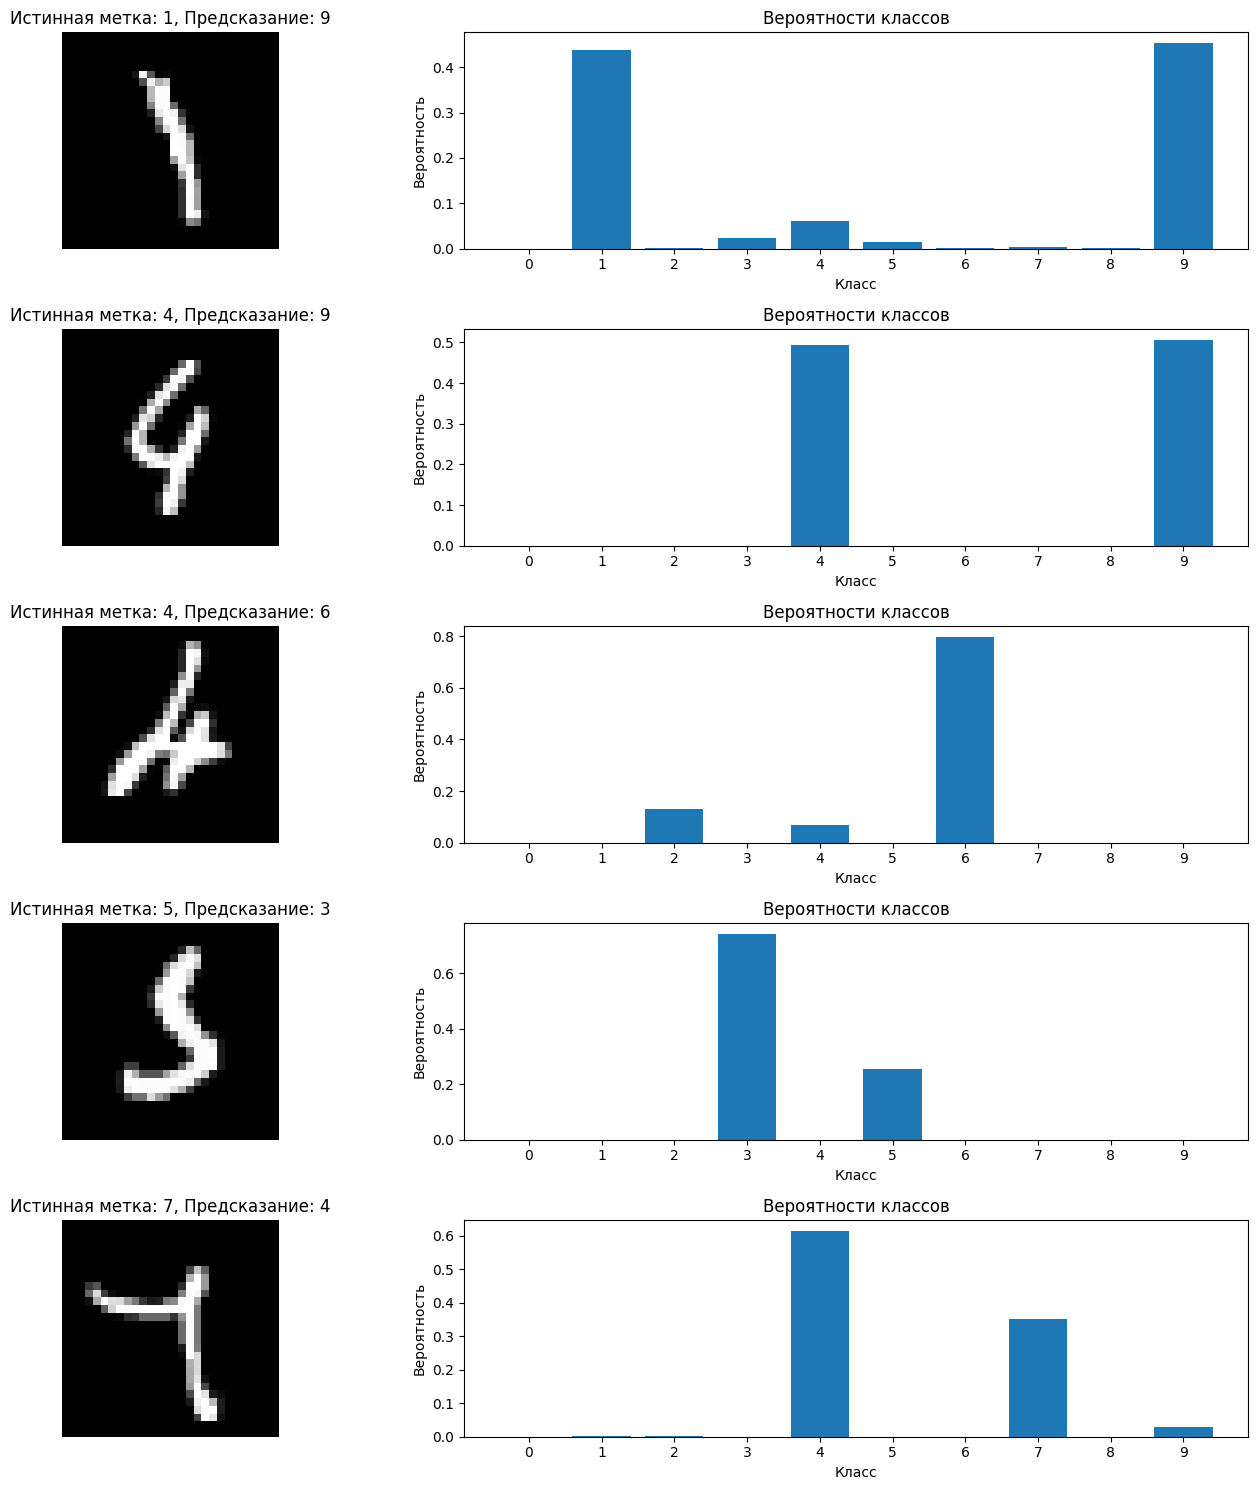

In [ ]:
# Анализ неправильно классифицированных примеров
def analyze_misclassifications(model, x_test, y_test, num_examples=5):
  # Получение предсказаний
  y_pred_prob = model.predict(x_test)
  y_pred = np.argmax(y_pred_prob, axis=1)
  # Нахождение неправильно классифицированных примеров
  misclassified_indices = np.where(y_pred != y_test)[0]
  # Вывод неправильно классифицированных примеров
  print(f"Примеры неправильно классифицированных изображений ({model.name}):")
  plt.figure(figsize=(15, 3 * num_examples))

  for i in range(min(num_examples, len(misclassified_indices))):
    idx = misclassified_indices[i]
    plt.subplot(num_examples, 2, 2*i+1)
    plt.imshow(x_test[idx], cmap='gray')
    plt.title(f"Истинная метка: {y_test[idx]}, Предсказание: {y_pred[idx]}")
    plt.axis('off')
    # Визуализация вероятностей для каждого класса
    plt.subplot(num_examples, 2, 2*i+2)
    plt.bar(range(10), y_pred_prob[idx])
    plt.xticks(range(10))
    plt.title('Вероятности классов')
    plt.xlabel('Класс')
    plt.ylabel('Вероятность')
  plt.tight_layout()
  plt.show()


# Анализ неправильно классифицированных примеров для каждой модели
simple_rnn_model.name = "SimpleRNN"
lstm_model.name = "LSTM"
bidirectional_lstm_model.name = "Bidirectional LSTM"
analyze_misclassifications(simple_rnn_model, x_test, y_test)
analyze_misclassifications(lstm_model, x_test, y_test)
analyze_misclassifications(bidirectional_lstm_model, x_test, y_test)


#### **Развертывание**

Полученные модели можно интегрировать в веб-интерфейс или мобильное приложение для классификации новых рукописных цифр (MNIST).

#### **Выводы**

Все три модели успешно обучились на MNIST и достигли высокой точности на тестовой выборке (> 97%).

Bidirectional LSTM показала наилучшие результаты по точности среди всех протестированных моделей.

Анализ неправильно классифицированных изображений выявил, что ошибки часто происходят при похожих формах (например, между 4 и 9).